# 1) Install dependencies and setup:

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import tensorflow as tf
import cv2
import imghdr
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 2) Preprocessing image directories:

In [ ]:
data_dir = "/content/drive/MyDrive/DeepLearning/DLP4_ImageClassifier"
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [ ]:
os.listdir(data_dir)

['happy', 'sad']

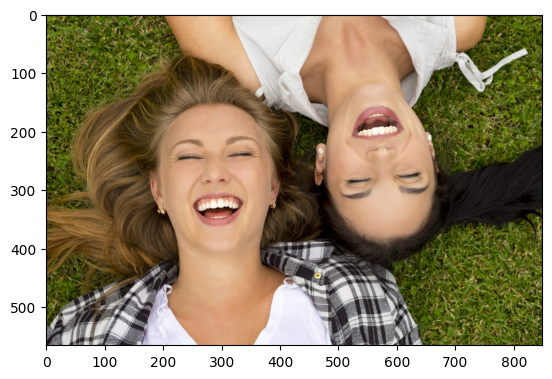

In [ ]:
# visualise an image
img = cv2.imread(os.path.join(data_dir,"happy","happy-people2.jpg"))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))   #cv2 converts image to BGR, matplotlib expects it to be RGB

In [ ]:
# REMOVE INVALID IMAGES AND IMG WITH INVALID EXTENSIONS

for image_class in os.listdir(data_dir):
  # print(image_class)
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class,  image)
    # print(image_path)
    try:
      image = cv2.imread(image_path) # read image as array
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print("image not in extension list: ", image_path)
        os.remove(image_path)
    except Exception as e:
      print("issue with image: ", image_path)

image not in extension list:  /content/drive/MyDrive/DeepLearning/DLP4_ImageClassifier/sad/1cd95b44e0d785987a6596d4baf940fc19-13-sad-white-man.2x.h473.w710.jpg
image not in extension list:  /content/drive/MyDrive/DeepLearning/DLP4_ImageClassifier/sad/depositphotos_36254119-stock-photo-desperate-sad-people.jpg
image not in extension list:  /content/drive/MyDrive/DeepLearning/DLP4_ImageClassifier/sad/depressed-senior-man-looking-unhappy-260nw-1326693131.jpg
image not in extension list:  /content/drive/MyDrive/DeepLearning/DLP4_ImageClassifier/sad/depositphotos_19568511-stock-photo-teenage-girl-looking-thoughtful-about.jpg
image not in extension list:  /content/drive/MyDrive/DeepLearning/DLP4_ImageClassifier/sad/african-american-depressive-sad-broken-260nw-475790911.jpg
image not in extension list:  /content/drive/MyDrive/DeepLearning/DLP4_ImageClassifier/sad/sad-person-pictures-2bnso9uiwlhrikrx.jpg
image not in extension list:  /content/drive/MyDrive/DeepLearning/DLP4_ImageClassifier/sad

# 3) Load data:

In [ ]:
tf.keras.utils.image_dataset_from_directory??

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir) #does batching, resize and add labels oob

Found 200 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

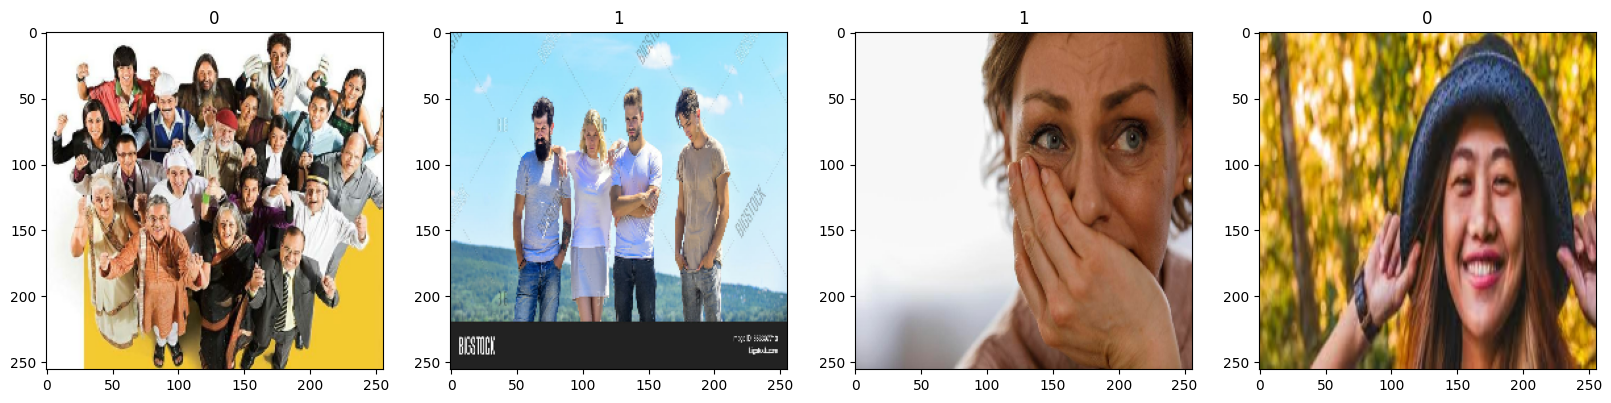

In [ ]:
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]): # [0] = image arrays
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx]) # [1] = labels of images , 0: happpy; 1: sad

# 4) Scale data:

In [ ]:
scaled_data = data.map(lambda x,y: (x/255, y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

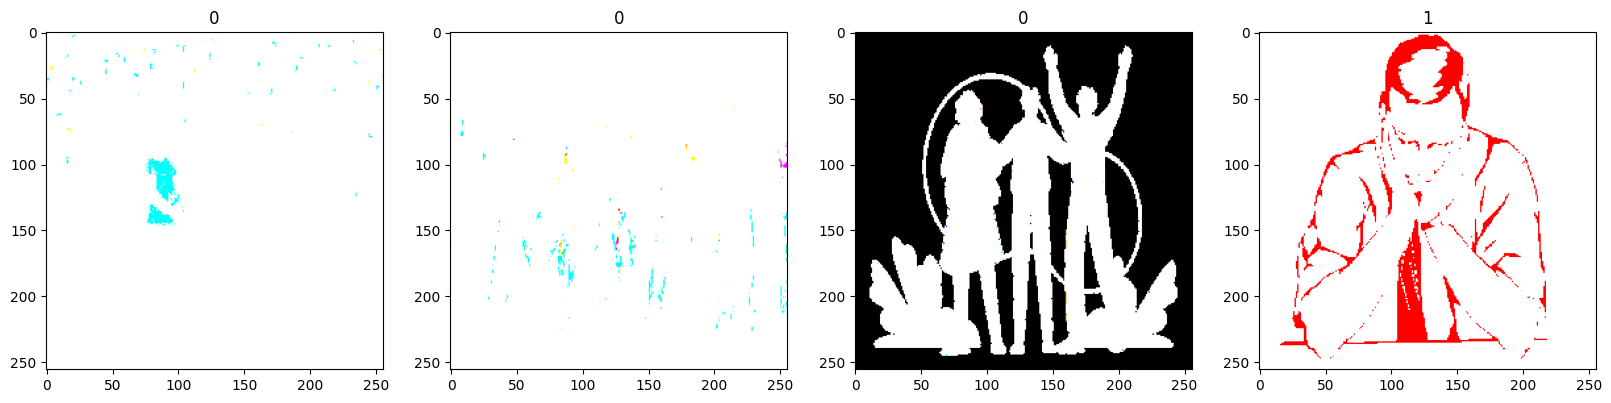

In [ ]:
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]): # [0] = image arrays
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# 5) Split data int train and test:

In [ ]:
train_size = int(len(scaled_data)*.7)
val_size = int(len(scaled_data)*.2)+1
test_size = int(len(scaled_data)*.1)+1

train_size, val_size, test_size

(4, 2, 1)

In [ ]:
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size+val_size).take(test_size)

# 6) Build CNN model:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

# 7) Train model:

In [ ]:
logdir='/content/drive/MyDrive/DeepLearning/DLP4_ImageClassifier/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 14s 3s/step - loss: 1.3712 - accuracy: 0.5703 - val_loss: 0.7336 - val_accuracy: 0.2812
Epoch 2/20
4/4 [==============================] - 12s 3s/step - loss: 0.8628 - accuracy: 0.3516 - val_loss: 0.6500 - val_accuracy: 0.7500
Epoch 3/20
4/4 [==============================] - 14s 4s/step - loss: 0.5830 - accuracy: 0.7188 - val_loss: 0.5261 - val_accuracy: 0.7031
Epoch 4/20
4/4 [==============================] - 15s 3s/step - loss: 0.5794 - accuracy: 0.6328 - val_loss: 0.5323 - val_accuracy: 0.7812
Epoch 5/20
4/4 [==============================] - 12s 3s/step - loss: 0.5623 - accuracy: 0.7500 - val_loss: 0.5164 - val_accuracy: 0.6875
Epoch 6/20
4/4 [==============================] - 13s 3s/step - loss: 0.5408 - accuracy: 0.6875 - val_loss: 0.4086 - val_accuracy: 0.7969
Epoch 7/20
4/4 [==============================] - 11s 3s/step - loss: 0.4830 - accuracy: 0.7969 - val_loss: 0.4708 - val_accuracy: 0.8125
Epoch 8/20
4/4 [==================

# 8) Plot performance:

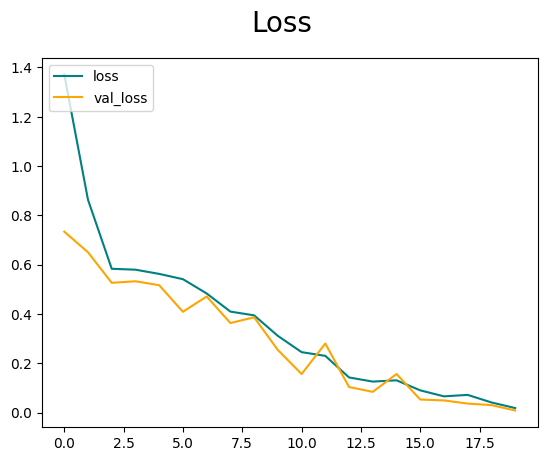

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

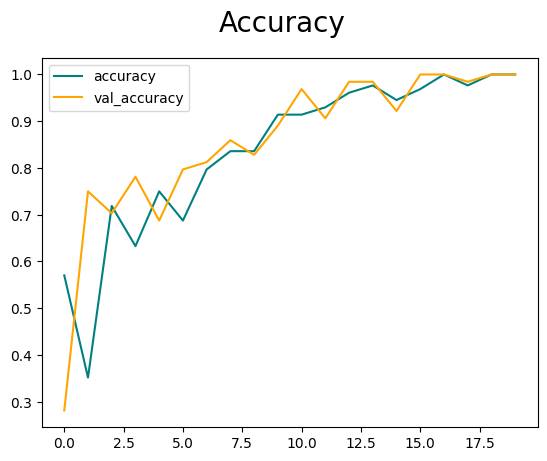

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9) evaluate performance:

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)


print("precision: ", pre.result())
print("recall: ", re.result())
print("accuracy: ",acc.result())

1/1 [==============================] - 0s 347ms/step
precision:  tf.Tensor(1.0, shape=(), dtype=float32)
recall:  tf.Tensor(1.0, shape=(), dtype=float32)
accuracy:  tf.Tensor(1.0, shape=(), dtype=float32)


In [ ]:
print("precision: ", pre.result().numpy())
print("recall: ", re.result().numpy())
print("accuracy: ", acc.result().numpy())

precision:  1.0
recall:  1.0
accuracy:  1.0


# 10) test images:

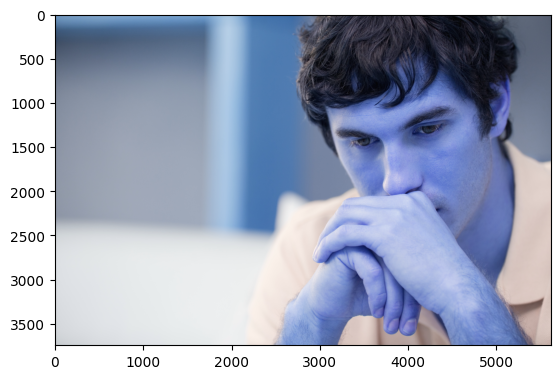

In [ ]:
img = cv2.imread("/content/drive/MyDrive/DeepLearning/DLP4_ImageClassifier/test1.jpg")
plt.imshow(img)
plt.show()

In [ ]:
resize.numpy().astype(int)

array([[[115, 150, 190],
        [117, 153, 193],
        [118, 153, 193],
        ...,
        [ 85,  95, 114],
        [ 79,  90, 108],
        [ 82,  92, 110]],

       [[108, 147, 186],
        [112, 151, 190],
        [116, 153, 192],
        ...,
        [ 83,  93, 111],
        [ 85,  92, 111],
        [ 83,  90, 109]],

       [[106, 145, 184],
        [110, 149, 188],
        [109, 145, 185],
        ...,
        [ 86,  96, 114],
        [ 84,  94, 112],
        [ 83,  93, 111]],

       ...,

       [[199, 203, 208],
        [203, 208, 211],
        [201, 206, 209],
        ...,
        [196, 174, 168],
        [197, 176, 168],
        [201, 179, 173]],

       [[198, 202, 206],
        [200, 205, 208],
        [202, 207, 210],
        ...,
        [199, 178, 170],
        [195, 174, 166],
        [191, 169, 163]],

       [[195, 199, 204],
        [201, 205, 210],
        [199, 204, 208],
        ...,
        [202, 180, 174],
        [203, 181, 175],
        [194, 173, 166]]

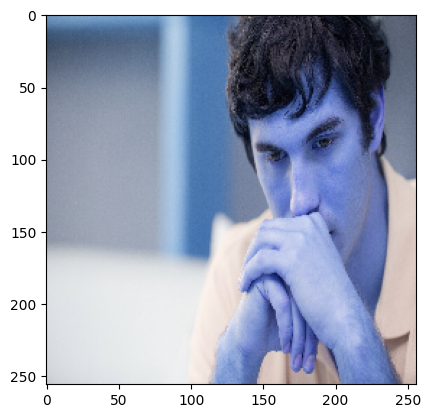

In [ ]:
resize = tf.image.resize(img, (256,256))
# plt.imshow(resize.numpy().astype(int))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 0s 82ms/step


array([[0.2077215]], dtype=float32)

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


In [ ]:
# save and load model:

from tensorflow.keras.models import load_model

model.save("/content/drive/MyDrive/DeepLearning/DLP4_ImageClassifier/dlp4.h5")
new_model = load_model("/content/drive/MyDrive/DeepLearning/DLP4_ImageClassifier/dlp4.h5")
new_model.predict(np.expand_dims(resize/255, 0))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 106ms/step


array([[0.2077215]], dtype=float32)